# About: Notebookの利用フローまとめ

----

Notebookの利用フローを図としてまとめる例です。

# 必要なツール

このNotebookの実行には[blockdiag](http://blockdiag.com/ja/blockdiag/)が必要です。

In [1]:
!which blockdiag

/home/bit_kun/.virtualenv/aws/bin/blockdiag


このNotebook環境にblockdiagコマンドがインストールされていない場合は、以下のようにしてblockdiagパッケージをインストールします。
(pipコマンドの場所は環境により異なります。)

In [2]:
#!pip2 install blockdiag

# ブロック図による一覧生成

以下のセルを実行(`Run All Below`)することで、Notebookがそれぞれどのような局面での利用を想定しているのか、ブロック図で確認することができます。

ブロック図は `images/notebooks-filled.svg` として保存し、他のNotebookから必要に応じて参照することとします。

一時ファイルは以下のディレクトリに作成します。

In [3]:
import tempfile
work_dir = tempfile.mkdtemp()
work_dir

'/tmp/tmpj1MoE9'

## 雛形の生成

まず、Notebookの利用フローを表したブロック図の雛形を作成します。

今回は雛形作成は人手により行っています。各ブロックには、Notebook名の先頭文字列を与えるものとします。

In [4]:
%%writefile {work_dir}/notebooks.diag
blockdiag {
    node_width = 210;
    node_height = 160;
    
    00_Prereq -> 01_01_Outline
    01_01_Outline -> 01_02_Accommodation_AWS -> 01_03_Set_Inventory -> 01_04_Install -> 01_05_Diagnostics
    01_01_Outline -> 01_02g_Accommodation_GCE [style=dotted]
    01_02g_Accommodation_GCE -> 01_03_Set_Inventory [style=dotted]
    01_05_Diagnostics -> 01_50_Add_Data_Node
    01_50_Add_Data_Node <- 01_51_Force_Merge [dir=none, style=dotted]
    01_50_Add_Data_Node <- 01_52_Backup_Restore [dir=none, style=dotted]
    01_50_Add_Data_Node -> 01_02_Accommodation_AWS
    01_04_Install -> 02_Search [folded]
    02_Search -> 03_Aggregation -> 04_Store_Data -> 05_Indexing
    
    group {
        label = "運用者向け"
        color = "#f0f8ff";
        group {
            orientation=portrait;
            color="#f0f8ff";

            00_Prereq
            01_01_Outline;
            group do {
                label="構築";
                color="#87cefa";

                01_02_Accommodation_AWS;
                01_02g_Accommodation_GCE;
                01_03_Set_Inventory;
                01_04_Install;
            }
        }
        group check {
            orientation=portrait;
            label="確認・診断";
            color="#87cefa";

            01_05_Diagnostics;
        }
        group action {
            orientation=portrait;
            label="改善";
            color="#87cefa";

            01_50_Add_Data_Node;
            01_51_Force_Merge;
            01_52_Backup_Restore;
        }
    }
    group use {
        label="利用者向け";
        color = "#f0f8ff";
        
        02_Search;
        03_Aggregation;
        04_Store_Data;
        05_Indexing;
    }
}

Writing /tmp/tmpj1MoE9/notebooks.diag


雛形を作成します。以下のような表示となります。

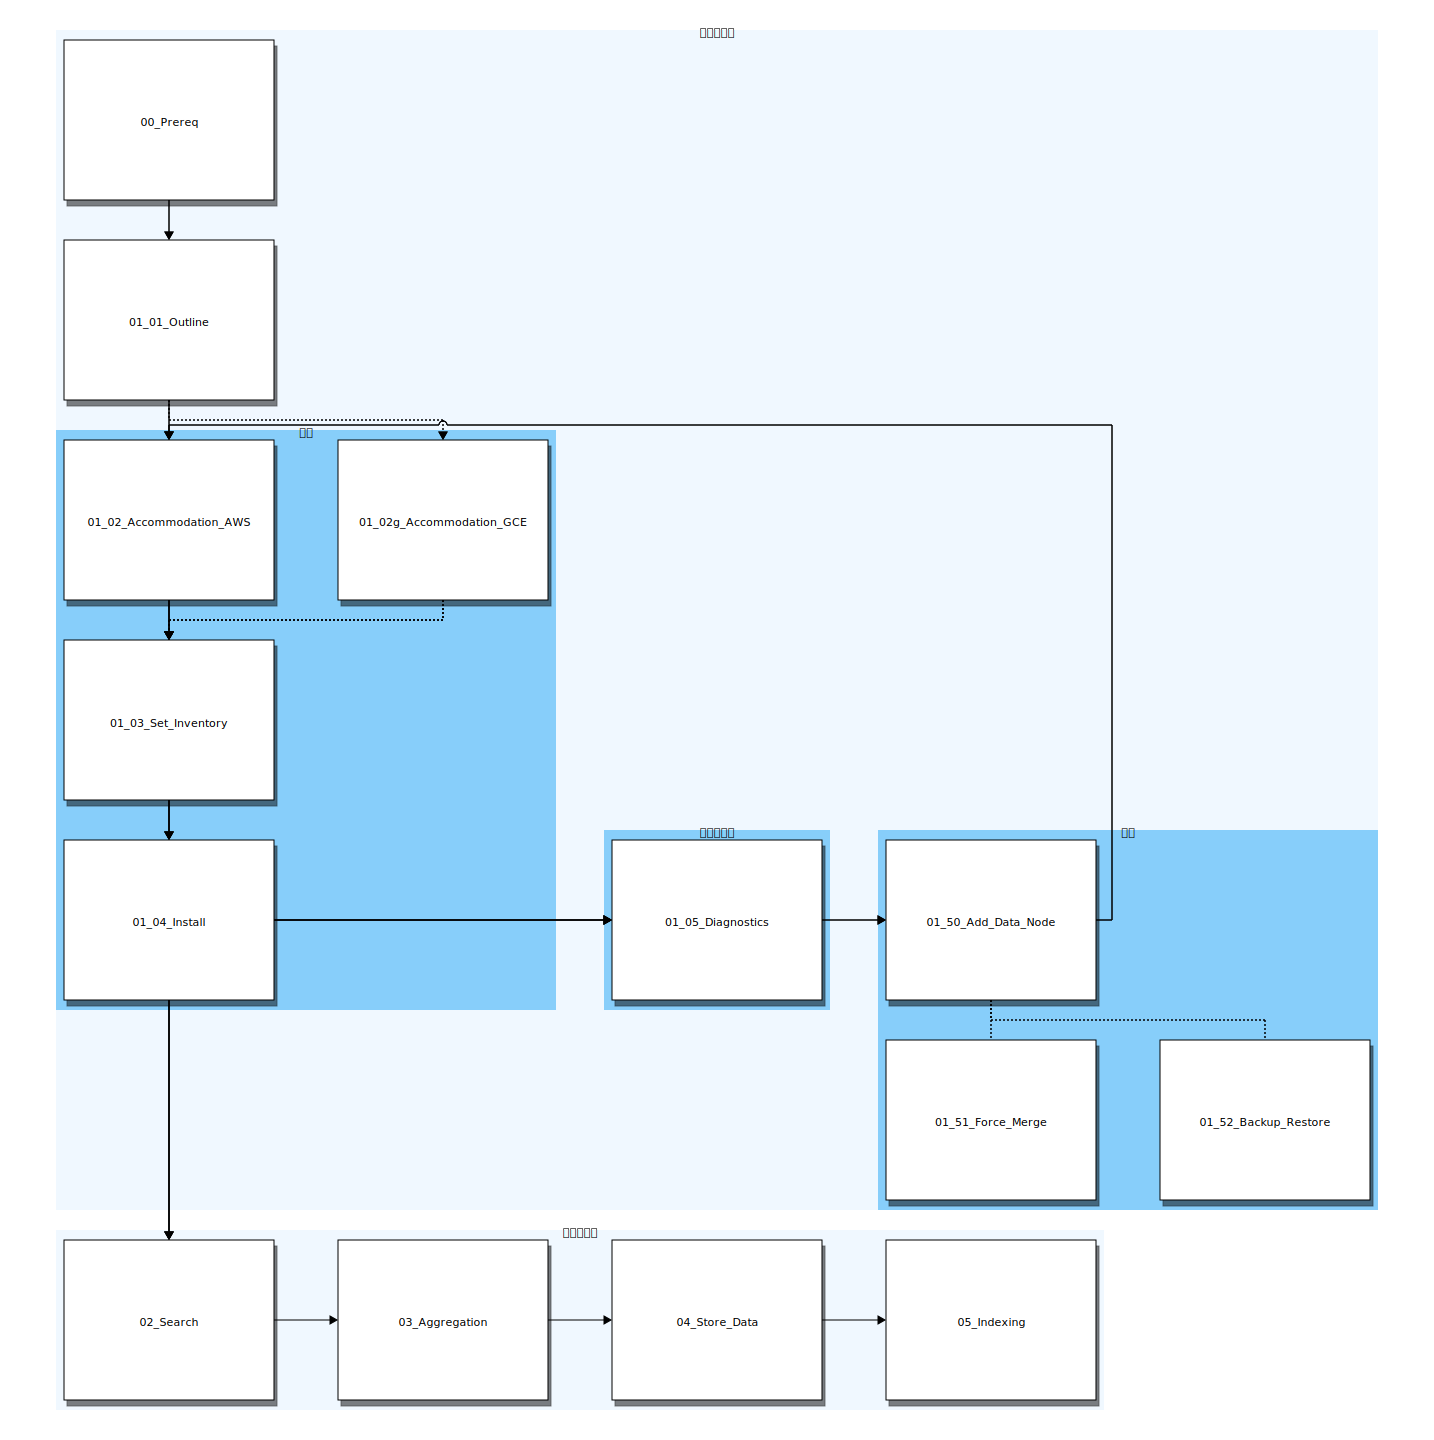

In [5]:
import os
from IPython.display import SVG

!blockdiag -f /usr/share/fonts/truetype/fonts-japanese-gothic.ttf -Tsvg \
           -o {work_dir}/notebooks.svg {work_dir}/notebooks.diag
SVG(filename=os.path.join(work_dir, 'notebooks.svg'))

## 詳細情報の埋め込み

生成した雛形に対して、見出しの情報など詳細な情報を埋め込みます。

この手順により、人手での図編集作業を最低限にとどめつつ、Notebookのわかりやすい利用フロー図を生成できるようにしています。

In [6]:
disabled = {'00_Prereq': (u'Prerequisites for Literate Computing via Notebook',
                          [(u'- Ansibleの設定', None),
                           (u'- 資材の準備', None)]),
            '01_02g_Accommodation_GCE': (u'Elastic Stackの構築手順：収容(GCE)',
                                         [(u'- Libraryの確認', None),
                                          (u'- Credentialの確認', None),
                                          (u'- インスタンスの起動', None),
                                          (u'- Inventory作成用のインスタンスリストを作成', None)])}

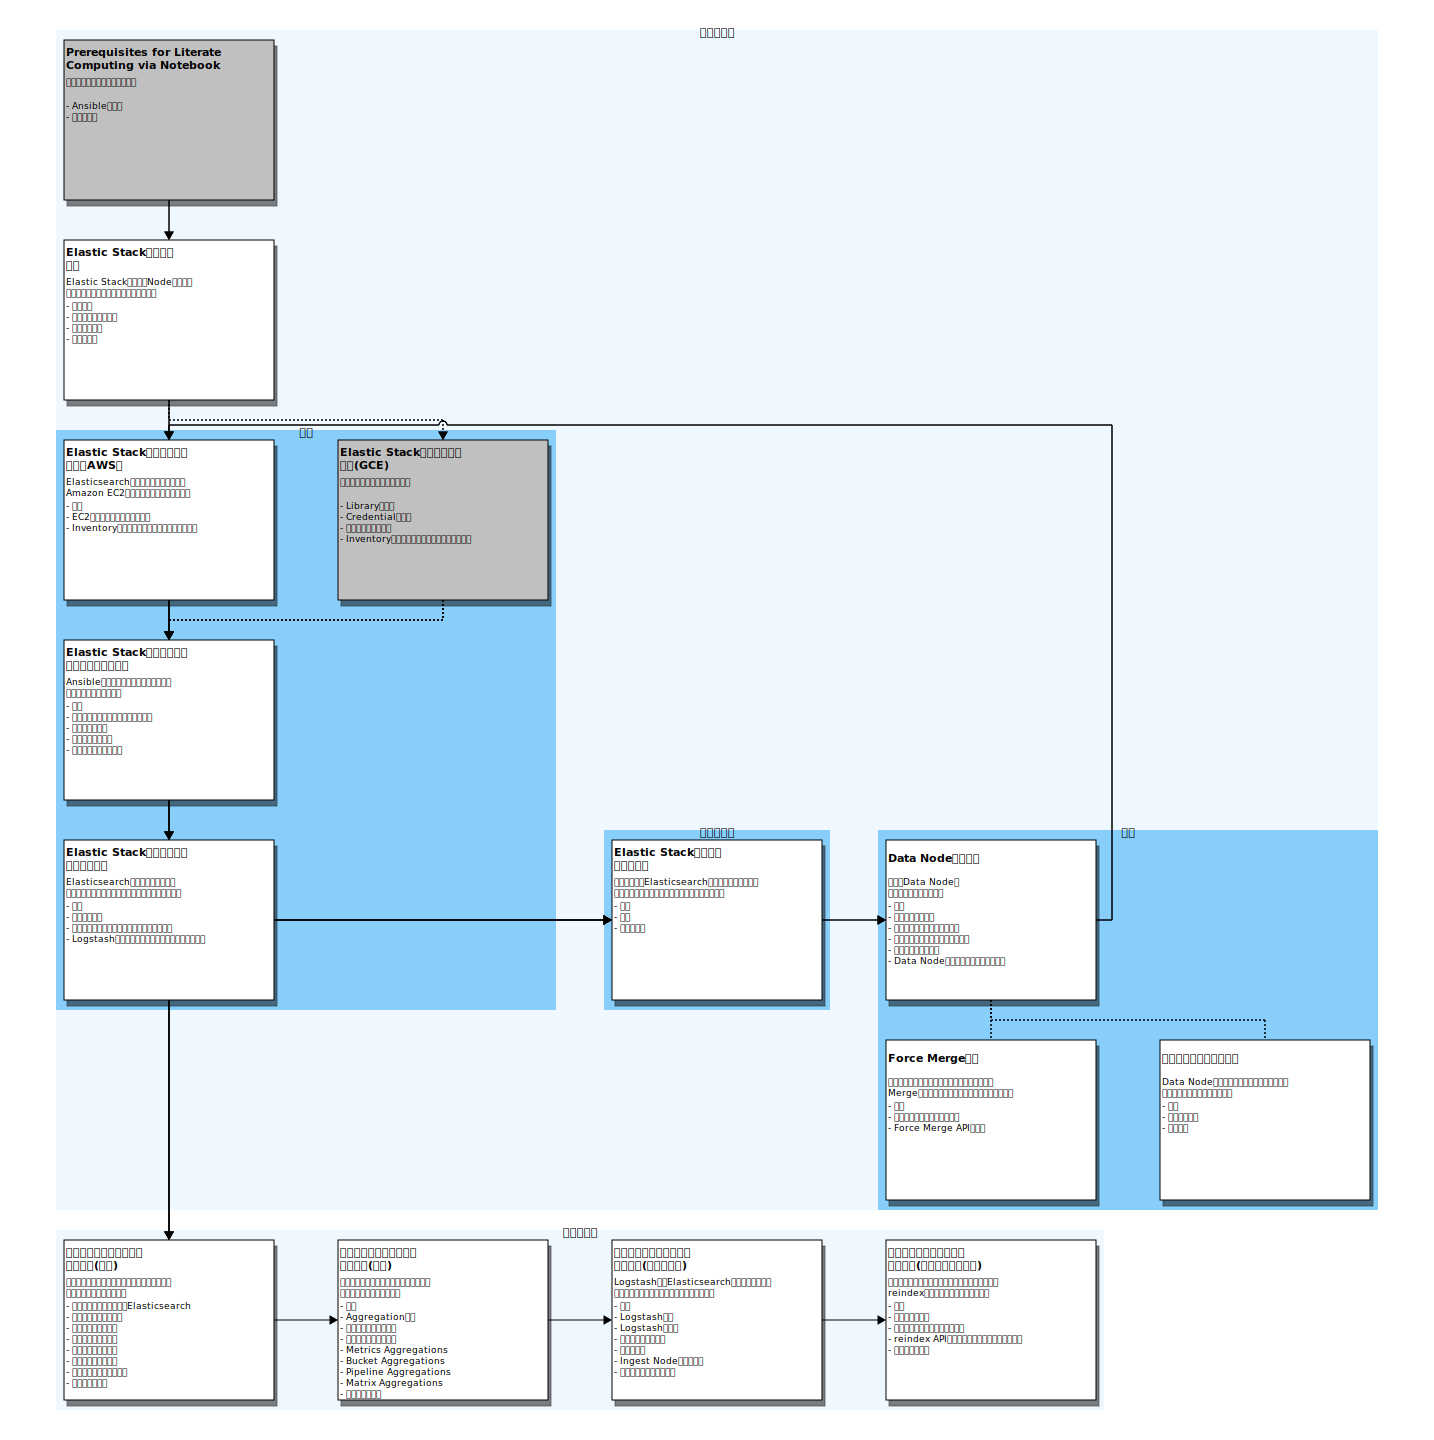

In [7]:
import re
from lxml import etree
%run scripts/generate-diagram.py

# Notebookの一覧列挙
ref_notebooks = filter(lambda m: m, map(lambda n: re.match(r'([0-9][0-9a-z]+_.*)\.ipynb', n), os.listdir('.')))
ref_notebooks = sorted(ref_notebooks, key=lambda m: m.group(1))
notebook_headers = [(m.group(1), parse_headers(m.group(0))) for m in ref_notebooks]

# 雛形の読み込み
tree = etree.parse(os.path.join(work_dir, 'notebooks.svg'))
        
# 雛形をNotebook情報で置き換え
for elem in list(tree.findall('{http://www.w3.org/2000/svg}text')):
    if elem.getprevious() is not None and elem.getprevious().tag == '{http://www.w3.org/2000/svg}rect' \
       and len(elem.text) > 0:
        target_headers = [(name, h) for name, h in notebook_headers if name.startswith(elem.text)]
        rect_elem = elem.getprevious()
        if len(target_headers) > 0:
            rect = ((int(rect_elem.attrib['x']), int(rect_elem.attrib['y'])), (int(rect_elem.attrib['width']),
                                                                               int(rect_elem.attrib['height'])))
        
            childpos = elem.getparent().index(elem)
            parent_elem = elem.getparent()
            remove_texts(elem)
            insert_title(parent_elem, childpos, rect, target_headers[0][1][0][0], target_headers[0][0] + '.ipynb')            
            insert_summary(parent_elem, childpos, rect, target_headers[0][1][0][1])
            insert_headers(parent_elem, childpos, rect, target_headers[0][1][1:])
        elif elem.text in disabled:
            rect_elem.attrib['fill'] = 'rgb(192, 192, 192)'
            rect = ((int(rect_elem.attrib['x']), int(rect_elem.attrib['y'])), (int(rect_elem.attrib['width']),
                                                                               int(rect_elem.attrib['height'])))
        
            childpos = elem.getparent().index(elem)
            parent_elem = elem.getparent()
            remove_texts(elem)
            insert_title(parent_elem, childpos, rect, disabled[elem.text][0])
            insert_summary(parent_elem, childpos, rect, u'本デモ環境では利用できません')
            insert_headers(parent_elem, childpos, rect, disabled[elem.text][1])
        else:
            print(elem.text)

# SVGの保存・表示
with open('images/notebooks-filled.svg', 'w') as f:
    f.write(etree.tostring(tree, method='xml', pretty_print=True))

SVG(filename='images/notebooks-filled.svg')

# 後始末

一時ファイルを削除します。

In [8]:
!rm -fr {work_dir}